In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marthenn","key":"dc8ab9fd8748dd211d7653ec0d6b015c"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                      title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                          DAIGT V2 Train Dataset                           29MB  2023-11-16 01:38:36           2132        201  1.0              
thedrcat/daigt-proper-train-dataset                      DAIGT Proper Train Dataset                      119MB  2023-11-05 14:03:25           1923        156  1.0              
muhammadbinimran/housing-price-prediction-data           Housing Price Prediction Data                   763KB  2023-11-21 17:56:32           9801        166  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset           LLM: 7 prompt training dataset                   41MB  202

In [4]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 171MB/s]


In [17]:
import os
import re
import shutil
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [18]:
import zipfile
local_zip = 'twitter-entity-sentiment-analysis.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')

In [19]:
os.listdir()

['.config',
 'kaggle.json',
 'twitter_training.csv',
 'twitter-entity-sentiment-analysis.zip',
 'twitter_validation.csv',
 'sample_data']

In [20]:
column_names = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_train = pd.read_csv('twitter_training.csv', header=None, names=column_names)
df_val = pd.read_csv('twitter_validation.csv', header=None, names=column_names)

df_combined = pd.concat([df_train, df_val], ignore_index = True)
df_combined = df_combined.drop(['Tweet ID', 'Entity'], axis=1)
print(df_combined.isnull().sum())
df_combined = df_combined.dropna()
print(df_combined.isnull().sum())

sentiments = pd.get_dummies(df_combined.Sentiment)
df_combined_ohe = pd.concat([df_combined, sentiments], axis=1)
df_combined_ohe = df_combined_ohe.drop(columns='Sentiment')

df_combined_ohe.head()

Sentiment          0
Tweet Content    686
dtype: int64
Sentiment        0
Tweet Content    0
dtype: int64


,Tweet Content,Irrelevant,Negative,Neutral,Positive
0,im getting on borderlands and i will murder yo...,0,0,0,1
1,I am coming to the borders and I will kill you...,0,0,0,1
2,im getting on borderlands and i will kill you ...,0,0,0,1
3,im coming on borderlands and i will murder you...,0,0,0,1
4,im getting on borderlands 2 and i will murder ...,0,0,0,1


In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def custom_standardization(text):
  punct = RegexpTokenizer(r'\w+')
  word_tokens = punct.tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_text = [word for word in word_tokens if word not in stop_words]
  lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
  return ' '.join(lemmatized_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df_combined_ohe = df_combined_ohe.drop_duplicates()
df_combined_ohe['Tweet Content'].apply(custom_standardization)

0                             im getting borderland murder
1                                   I coming border I kill
2                               im getting borderland kill
3                              im coming borderland murder
4                           im getting borderland 2 murder
                               ...                        
75670    Suikoden 2 1 Alex Kidd Miracle World Persona 3...
75671    Thank Matching fund Home Depot RW payment 2155...
75673    Late night stream boy Come watch warzone run s...
75677    Toronto art culture capital Canada wonder If w...
75678    tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
Name: Tweet Content, Length: 70252, dtype: object

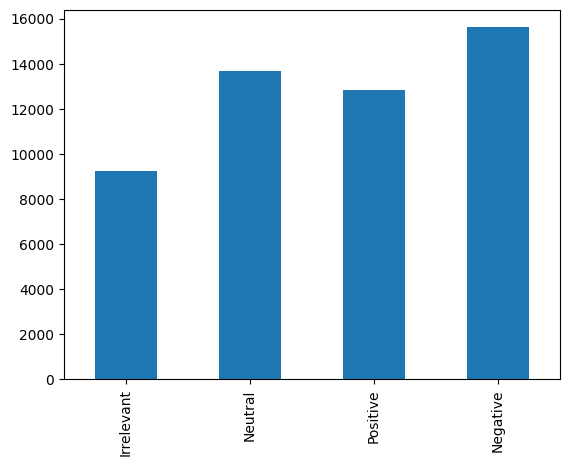

Irrelevant     9232
Neutral       13663
Positive      12828
Negative      15618
dtype: int64


In [23]:
df_combined_ohe['word_count'] = df_combined_ohe['Tweet Content'].str.split().apply(len)
df_combined_ohe = df_combined_ohe[df_combined_ohe['word_count'] >= 10]
df_combined_ohe[['Irrelevant', 'Neutral', 'Positive', 'Negative']].sum().plot(kind='bar')
plt.show()
print(df_combined_ohe[['Irrelevant', 'Neutral', 'Positive', 'Negative']].sum())

In [24]:
content = df_combined_ohe['Tweet Content'].values
label = df_combined_ohe[['Irrelevant', 'Neutral', 'Positive', 'Negative']].values

In [25]:
from sklearn.model_selection import train_test_split
x_latih, x_test, y_latih, y_test = train_test_split(content, label, test_size=0.2)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= 5000, oov_token='-')
tokenizer.fit_on_texts(x_latih)
tokenizer.fit_on_texts(x_test)

sekuens_latih = tokenizer.texts_to_sequences(x_latih)
sekuens_test = tokenizer.texts_to_sequences(x_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

In [38]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
from sklearn.model_selection import KFold

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
num_epochs = 30
history = model.fit(
      padded_latih, y_latih,
      epochs=num_epochs,
      validation_data=(padded_test, y_test),
      callbacks=[myCallback()],
      batch_size = 64
    )

Epoch 1/30
321/321 [==============================] - 23s 63ms/step - loss: 1.1569 - accuracy: 0.4917 - val_loss: 0.9383 - val_accuracy: 0.6220
Epoch 2/30
321/321 [==============================] - 8s 24ms/step - loss: 0.7513 - accuracy: 0.7140 - val_loss: 0.7039 - val_accuracy: 0.7345
Epoch 3/30
321/321 [==============================] - 6s 18ms/step - loss: 0.5429 - accuracy: 0.8027 - val_loss: 0.6398 - val_accuracy: 0.7677
Epoch 4/30
321/321 [==============================] - 5s 15ms/step - loss: 0.4436 - accuracy: 0.8421 - val_loss: 0.5837 - val_accuracy: 0.7909
Epoch 5/30
321/321 [==============================] - 5s 15ms/step - loss: 0.3687 - accuracy: 0.8715 - val_loss: 0.5367 - val_accuracy: 0.8124
Epoch 6/30
321/321 [==============================] - 4s 12ms/step - loss: 0.3070 - accuracy: 0.8960 - val_loss: 0.5555 - val_accuracy: 0.8140
Epoch 7/30
321/321 [==============================] - 4s 11ms/step - loss: 0.2565 - accuracy: 0.9123 - val_loss: 0.5181 - val_accuracy: 0.830

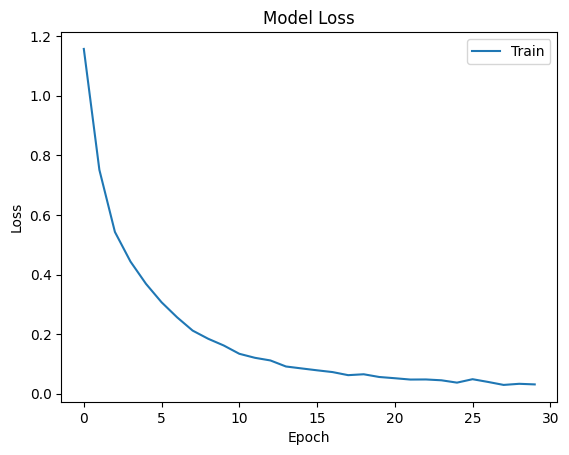

In [33]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

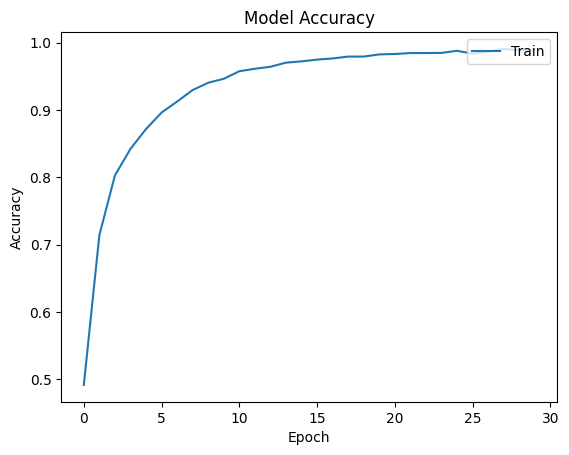

In [34]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

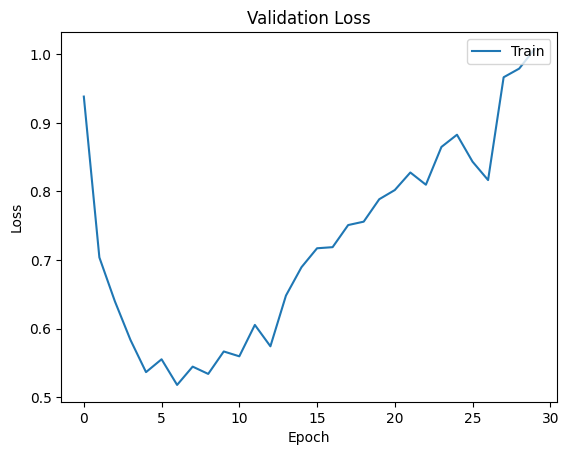

In [35]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

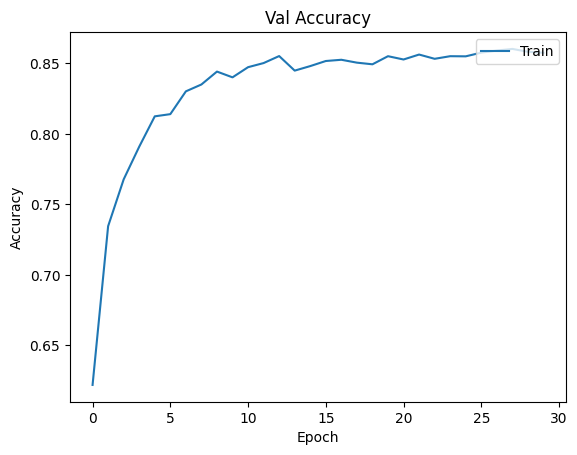

In [36]:
plt.plot(history.history['val_accuracy'])
plt.title('Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()